In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_encoder import hdc_encoder
from laplace_hdc_classifier import train_hdc_classifier, test_hdc_classifier
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")


Using device:	cuda:0


In [2]:
hyperdim = 5000 
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
epochs=10

In [3]:
class_names = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

# load the MNIST training data
train_data = datasets.FashionMNIST(
    '../../Data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Load the MNIST testing data
test_data = datasets.FashionMNIST(
    '../../Data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

num_classes = len(class_names)
print(num_classes)

10


lambda = 0.013683437369763851


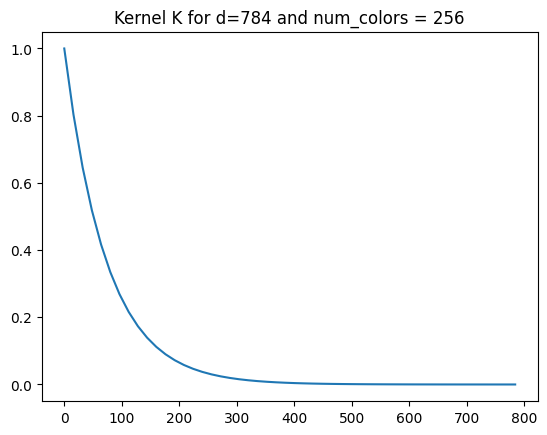

In [4]:
# Determining Lambda from random 1000 samples
batch_size = 1024
num_colors = 256

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1)

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

In [5]:
encoder = hdc_encoder(d, hyperdim, kernel, encoder_mode)
print(f"mode: {encoder_mode}\nHyperdimension: {encoder.hyperdim}")

mode: shift_1d
Hyperdimension: 5000


In [6]:
batch_size = 128
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [7]:
hyperdims = loadmat('../EHDGNet_FashionMNIST_nHD.mat')['EHDGNet_FashionMNIST_nHD']
hyperdims = np.mean(hyperdims, axis=1, dtype=int)
hyperdims

array([ 5000,  7333,  9000, 11333, 13333, 15000, 17333, 19000, 21333,
       23000, 25000])

In [8]:
num_workers = 2
pin_memory=True
n_splits = 20
split_size = len(test_data) // n_splits
hyperdims = hyperdims
accuracies = np.zeros((len(hyperdims), n_splits))
for i, nHDC in enumerate(hyperdims):
    print(f'Hyperdimension: {nHDC} Started --------------')
    # Train
    encoder = hdc_encoder(d, nHDC, kernel, encoder_mode)
    train_hdc = encoder.encode(train_loader)
    train_loader_hdc = DataLoader(
        train_hdc,
        batch_size=750,
        shuffle=True,
        num_workers=0,      # <-- no background workers
        pin_memory=False    # <-- nothing to pin; data is on GPU
    )
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=10)
    print(f'Encoding Train Data and Training the Model for nHDC={nHDC} finished')
    for split_idx in tqdm(range(n_splits)):
        # Test
        start_idx = split_idx * split_size
        end_idx = start_idx + split_size
        split_subset = Subset(test_data, range(start_idx, end_idx))
        split_loader = DataLoader(
            split_subset,
            batch_size=128,
            shuffle=False,
            num_workers=num_workers,   # 2, as you set above
            pin_memory=pin_memory      # True
        )
        split_hdc = encoder.encode(split_loader)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=128,
            shuffle=True,
            num_workers=0,
            pin_memory=False
        )
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)
    print(f'Hyperdimension: {nHDC} Finished. Average Accuracy over 20 splits: {np.mean(accuracies[i])}')


Hyperdimension: 5000 Started --------------


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Encoding Train Data and Training the Model for nHDC=5000 finished


100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Hyperdimension: 5000 Finished. Average Accuracy over 20 splits: 0.8520999999999999
Hyperdimension: 7333 Started --------------


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Encoding Train Data and Training the Model for nHDC=7333 finished


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Hyperdimension: 7333 Finished. Average Accuracy over 20 splits: 0.8671
Hyperdimension: 9000 Started --------------


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Encoding Train Data and Training the Model for nHDC=9000 finished


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


Hyperdimension: 9000 Finished. Average Accuracy over 20 splits: 0.8690000000000001
Hyperdimension: 11333 Started --------------


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Encoding Train Data and Training the Model for nHDC=11333 finished


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Hyperdimension: 11333 Finished. Average Accuracy over 20 splits: 0.8787999999999998
Hyperdimension: 13333 Started --------------


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Encoding Train Data and Training the Model for nHDC=13333 finished


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


Hyperdimension: 13333 Finished. Average Accuracy over 20 splits: 0.8791000000000002
Hyperdimension: 15000 Started --------------


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Encoding Train Data and Training the Model for nHDC=15000 finished


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hyperdimension: 15000 Finished. Average Accuracy over 20 splits: 0.876
Hyperdimension: 17333 Started --------------


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Encoding Train Data and Training the Model for nHDC=17333 finished


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Hyperdimension: 17333 Finished. Average Accuracy over 20 splits: 0.8778000000000002
Hyperdimension: 19000 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Encoding Train Data and Training the Model for nHDC=19000 finished


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Hyperdimension: 19000 Finished. Average Accuracy over 20 splits: 0.8841999999999999
Hyperdimension: 21333 Started --------------


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Encoding Train Data and Training the Model for nHDC=21333 finished


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Hyperdimension: 21333 Finished. Average Accuracy over 20 splits: 0.884
Hyperdimension: 23000 Started --------------


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Encoding Train Data and Training the Model for nHDC=23000 finished


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Hyperdimension: 23000 Finished. Average Accuracy over 20 splits: 0.8854000000000001
Hyperdimension: 25000 Started --------------


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

Hyperdimension: 25000 Finished. Average Accuracy over 20 splits: 0.8819999999999999


In [9]:
np.mean(accuracies, axis=1)

array([0.8521, 0.8671, 0.869 , 0.8788, 0.8791, 0.876 , 0.8778, 0.8842,
       0.884 , 0.8854, 0.882 ])

In [10]:
savemat('LaplaceHDC_FashionMNIST.mat', {'LaplaceHDC_FashionMNIST': accuracies*100})